In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)




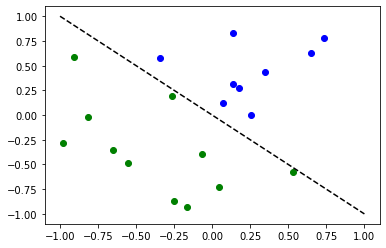

In [4]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [8]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [10]:
# construct QNN
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], np.random.rand(opflow_qnn.num_weights))

array([[0.09570312]])

In [13]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(), callback=callback_graph)

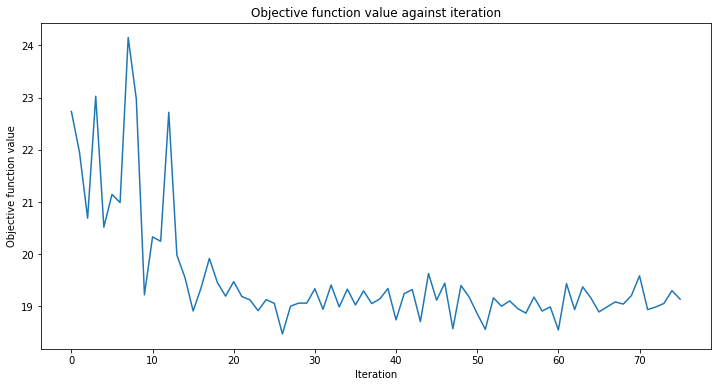

0.55

In [15]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X, y)

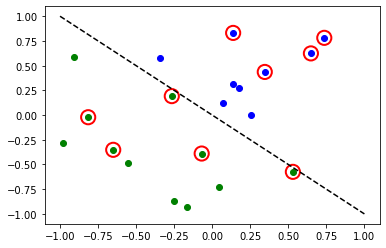

In [16]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

C:\Users\lenovo\anaconda3\envs\google-trace-analysis\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


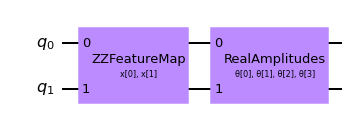

In [17]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output='mpl')


In [18]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return '{:b}'.format(x).count('1') % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)


In [20]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

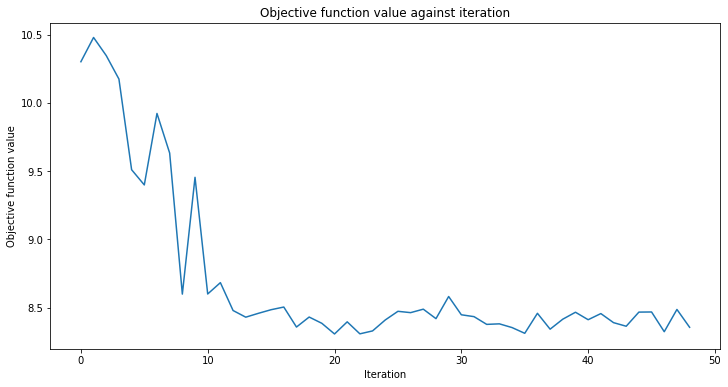

0.45

In [21]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(X, y01)

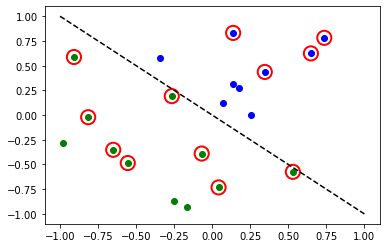

In [23]:
# evaluate data points
y_predict = circuit_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

Variational Quantum Classifier (VQC)

In [24]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=COBYLA(),
          quantum_instance=quantum_instance,
          callback=callback_graph)

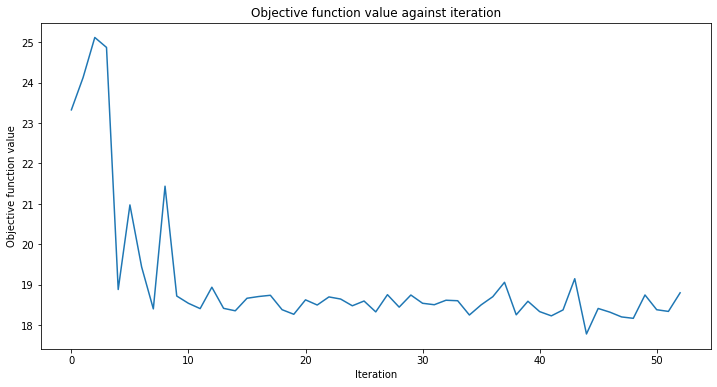

0.55

In [25]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

In [ ]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

Regression

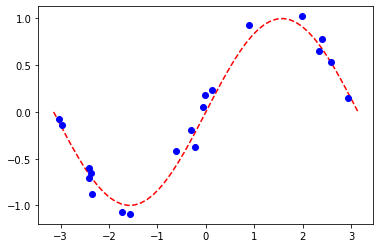

In [26]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X[:,0]) + eps*(2*np.random.rand(num_samples)-1)

plt.plot(X_, f(X_), 'r--')
plt.plot(X, y, 'bo')
plt.show()

Regresstion using opflowQnn

In [29]:
# construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter('y')
ansatz = QuantumCircuit(1, name='vf')
ansatz.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=quantum_instance)




In [30]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(neural_network=regression_opflow_qnn,
                                   loss='l2',
                                   optimizer=L_BFGS_B(),
                                   callback=callback_graph)

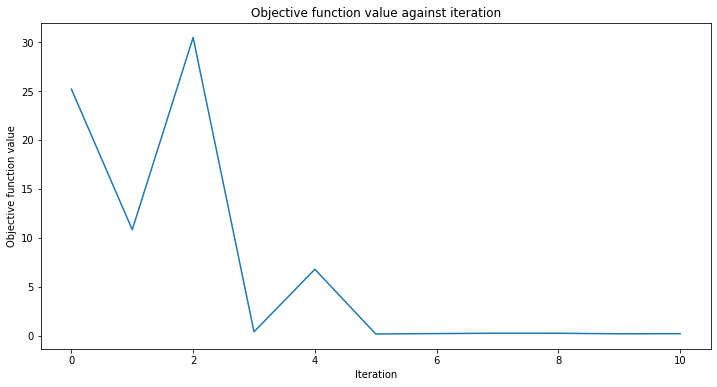

0.9706708863559225

In [39]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

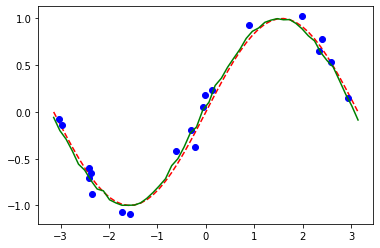

In [32]:
# plot target function
plt.plot(X_, f(X_), 'r--')

# plot data
plt.plot(X, y, 'bo')

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, 'g-')
plt.show()

Regression with the Variational Quantum Regressor (VQR)

In [34]:
vqr = VQR(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=L_BFGS_B(),
          quantum_instance=quantum_instance,
          callback=callback_graph)

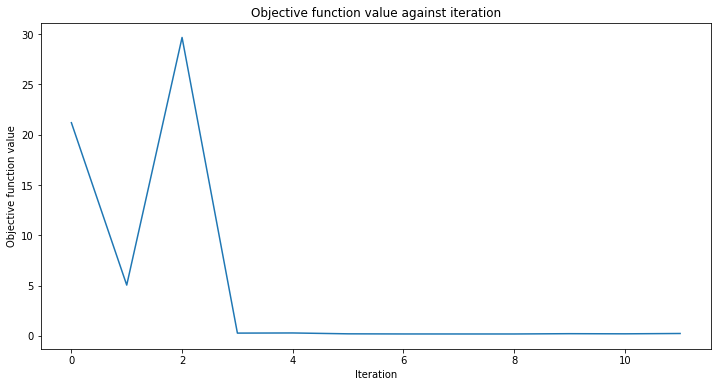

0.9762856705804903

In [35]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

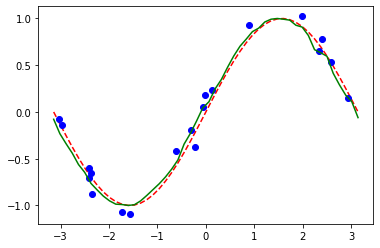

In [36]:
# plot target function
plt.plot(X_, f(X_), 'r--')

# plot data
plt.plot(X, y, 'bo')

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, 'g-')
plt.show()

In [37]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright



C:\Users\lenovo\anaconda3\envs\google-trace-analysis\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
